# CNO Model Inference Demo

This notebook demonstrates how to load a pretrained CNO (Convolutional Neural Operator) model and perform inference on Poisson equation data.

The model was trained using `TrainCNO.py` with 1024 training samples on the Poisson equation benchmark.


## 1. Import Required Libraries


In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import DataLoader
import os
import sys

# set the path of the script to the project for all cells
sys.path.append('..')

# Import the necessary modules
from Problems.CNOBenchmarks import SinFrequency
from Physics_NO.loss_functions.Relative_loss import Relative_loss

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
print(f'PyTorch version: {torch.__version__}')


Using device: cpu
PyTorch version: 2.7.1+cu126


## 2. Load Model Configuration and Pretrained Weights


In [10]:
'''
Useful model folder paths:
(Trained) "../TrainedModels/CNO_1024poisson"
(With pretraining) "../TrainedModels/PINO_CNO_pretrainedpoisson"
(No pretraining) "../TrainedModels/PINO_CNO_no_pretrainingpoisson"
(With pretraining and new loss) "../TrainedModels/PINO+_CNO_pretrainedpoisson"
(No pretraining and new loss) "../TrainedModels/PINO+_CNO_no_pretrainingpoisson"



'''


# Define model folder path
model_folder = "../TrainedModels/PINO+_CNO_pretrainedpoisson"

# Load training properties
training_props_df = pd.read_csv(os.path.join(model_folder, 'training_properties.txt'), 
                               header=None, index_col=0)
training_properties = training_props_df.to_dict()[1]

# Load network architecture
net_arch_df = pd.read_csv(os.path.join(model_folder, 'net_architecture.txt'), 
                         header=None, index_col=0)
model_architecture = net_arch_df.to_dict()[1]
# parse the model_architecture dictionary
for key, value in model_architecture.items():
    if isinstance(value, str) and value.isdigit():
        model_architecture[key] = int(value)
    elif isinstance(value, str) and value.replace('.', '', 1).isdigit():
        model_architecture[key] = float(value)
    else:
        model_architecture[key] = value


print("Training Properties:")
for key, value in training_properties.items():
    print(f"  {key}: {value}")

print("\nModel Architecture:")
for key, value in model_architecture.items():
    print(f"  {key}: {type(value)} {value}")

Training Properties:
  learning_rate: 0.0003
  weight_decay: 1e-10
  scheduler_step: 10.0
  scheduler_gamma: 0.98
  epochs: 100.0
  batch_size: 16.0
  exp: 1.0
  training_samples: 1024.0
  pde_decay: 1.0
  boundary_decay: 1.0
  pad_factor: 0.0

Model Architecture:
  N_layers: <class 'int'> 4
  channel_multiplier: <class 'int'> 16
  N_res: <class 'int'> 5
  N_res_neck: <class 'int'> 5
  in_size: <class 'int'> 64
  retrain: <class 'int'> 4
  kernel_size: <class 'int'> 3
  FourierF: <class 'int'> 0
  activation: <class 'str'> cno_lrelu
  cutoff_den: <class 'float'> 2.0001
  lrelu_upsampling: <class 'int'> 2
  half_width_mult: <class 'float'> 0.8
  filter_size: <class 'int'> 6
  radial_filter: <class 'int'> 0
  out_size: <class 'int'> 1


In [11]:
# Load the pretrained model
model_path = os.path.join(model_folder, 'model.pkl')

# Fix for PyTorch 2.6+ - need to set weights_only=False for full model loading
# This is safe since we trust the source of this model file
model = torch.load(model_path, map_location=device, weights_only=False)
model.eval()  # Set to evaluation mode

print(f"Model loaded successfully from {model_path}")
print(f"Model is on device: {next(model.parameters()).device}")

# Print model summary
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


Model loaded successfully from ../TrainedModels/PINO+_CNO_pretrainedpoisson/model.pkl
Model is on device: cpu
Total parameters: 2,751,729
Trainable parameters: 2,751,729


## 3. Setup Data Loaders

We'll create data loaders for both training and test data using the same configuration as during training.


In [12]:
# Extract parameters for data loading
batch_size = int(training_properties['batch_size'])
training_samples = int(training_properties['training_samples'])
in_size = int(model_architecture['in_size'])

# Create the SinFrequency data loader (Poisson equation)
poisson_data = SinFrequency(
    network_properties=model_architecture,
    device=device,
    batch_size=batch_size,
    training_samples=training_samples,
    s=in_size,
    in_dist=True  # In-distribution test data
)

print(f"Data loaders created:")
print(f"  Training samples: {len(poisson_data.train_loader.dataset)}")
print(f"  Validation samples: {len(poisson_data.val_loader.dataset)}")
print(f"  Test samples: {len(poisson_data.test_loader.dataset)}")
print(f"  Grid resolution: {in_size}x{in_size}")


in_size: 64
type(in_size): <class 'int'>
Domain not found in file, using default value of 1.0
Domain not found in file, using default value of 1.0
Domain not found in file, using default value of 1.0
Data loaders created:
  Training samples: 1024
  Validation samples: 128
  Test samples: 256
  Grid resolution: 64x64


/cluster/home/lkellijs/pino/lib/python3.12/site-packages/torch/utils/data/dataloader.py:626: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## 4. Single Sample Inference Example

Let's perform inference on a single sample and visualize the results.


In [13]:
# Get a single sample from test data
test_iter = iter(poisson_data.test_loader)
input_batch, output_batch = next(test_iter)

# Move to device
input_batch = input_batch.to(device)
output_batch = output_batch.to(device)

# Perform inference
with torch.no_grad():
    prediction_batch = model(input_batch)

# Convert to numpy for plotting (take first sample from batch)
input_sample = input_batch[0, 0].cpu().numpy()  # First channel (input field)
ground_truth = output_batch[0, 0].cpu().numpy()
prediction = prediction_batch[0, 0].cpu().numpy()

print(f"Input shape: {input_sample.shape}")
print(f"Ground truth shape: {ground_truth.shape}")
print(f"Prediction shape: {prediction.shape}")


Input shape: (64, 64)
Ground truth shape: (64, 64)
Prediction shape: (64, 64)


In [14]:
cmap = 'gist_ncar'

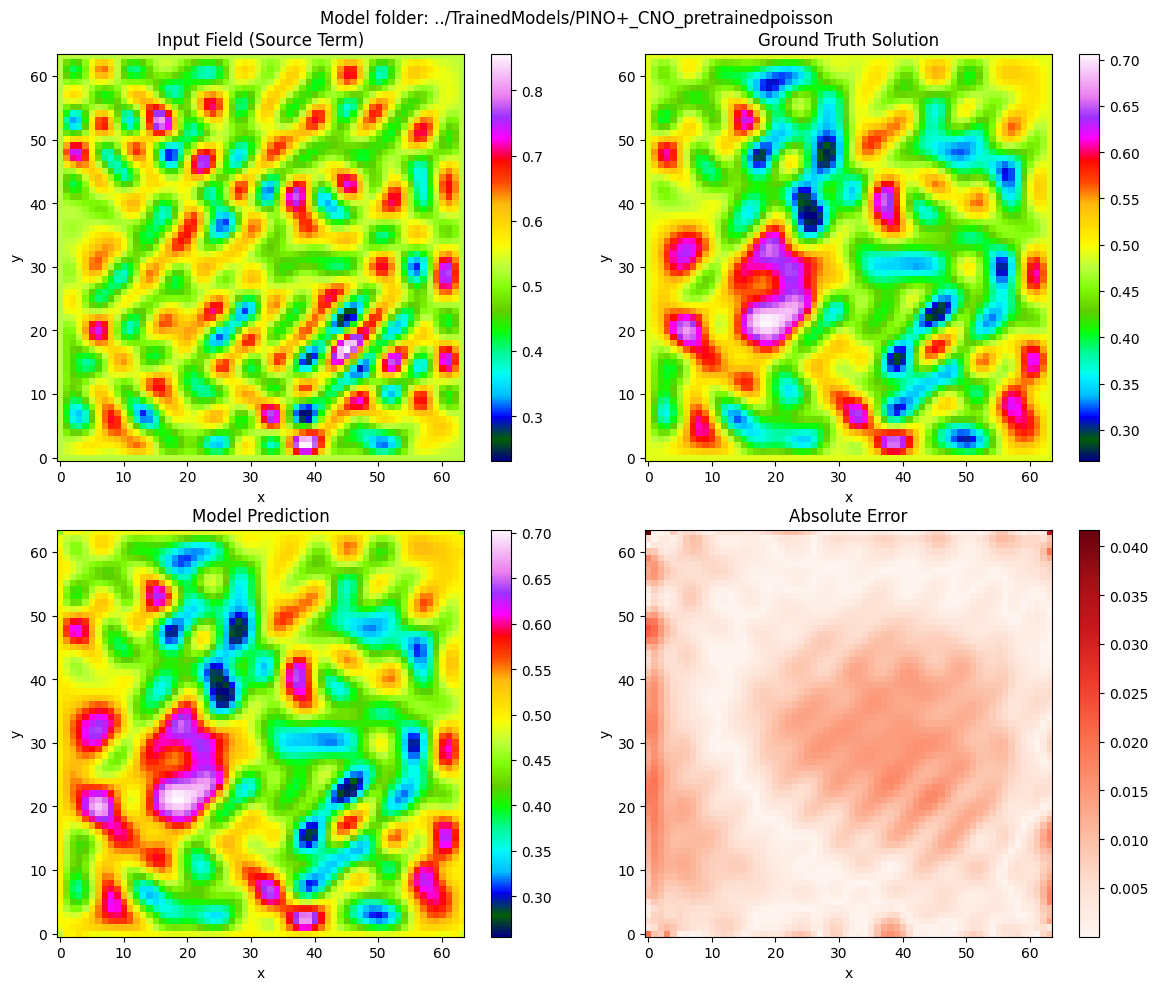

Relative L2 error for this sample: 0.0162 (1.62%)


In [15]:

# Visualize the results
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# add model_folder path as title
fig.suptitle(f"Model folder: {model_folder}")

# Input field (source term)
im1 = axes[0, 0].imshow(input_sample, cmap=cmap, origin='lower')
axes[0, 0].set_title('Input Field (Source Term)')
axes[0, 0].set_xlabel('x')
axes[0, 0].set_ylabel('y')
plt.colorbar(im1, ax=axes[0, 0])

# Ground truth solution
im2 = axes[0, 1].imshow(ground_truth, cmap=cmap, origin='lower')
axes[0, 1].set_title('Ground Truth Solution')
axes[0, 1].set_xlabel('x')
axes[0, 1].set_ylabel('y')
plt.colorbar(im2, ax=axes[0, 1])

# Model prediction
im3 = axes[1, 0].imshow(prediction, cmap=cmap, origin='lower')
axes[1, 0].set_title('Model Prediction')
axes[1, 0].set_xlabel('x')
axes[1, 0].set_ylabel('y')
plt.colorbar(im3, ax=axes[1, 0])

# Error map
error = np.abs(ground_truth - prediction)
im4 = axes[1, 1].imshow(error, cmap='Reds', origin='lower')
axes[1, 1].set_title('Absolute Error')
axes[1, 1].set_xlabel('x')
axes[1, 1].set_ylabel('y')
plt.colorbar(im4, ax=axes[1, 1])

plt.tight_layout()
plt.show()

# Calculate relative error for this sample
rel_error = np.linalg.norm(ground_truth - prediction) / np.linalg.norm(ground_truth)
print(f"Relative L2 error for this sample: {rel_error:.4f} ({rel_error*100:.2f}%)")


## 5. Multiple Sample Visualization

Let's visualize predictions on multiple samples to get a better sense of model performance.


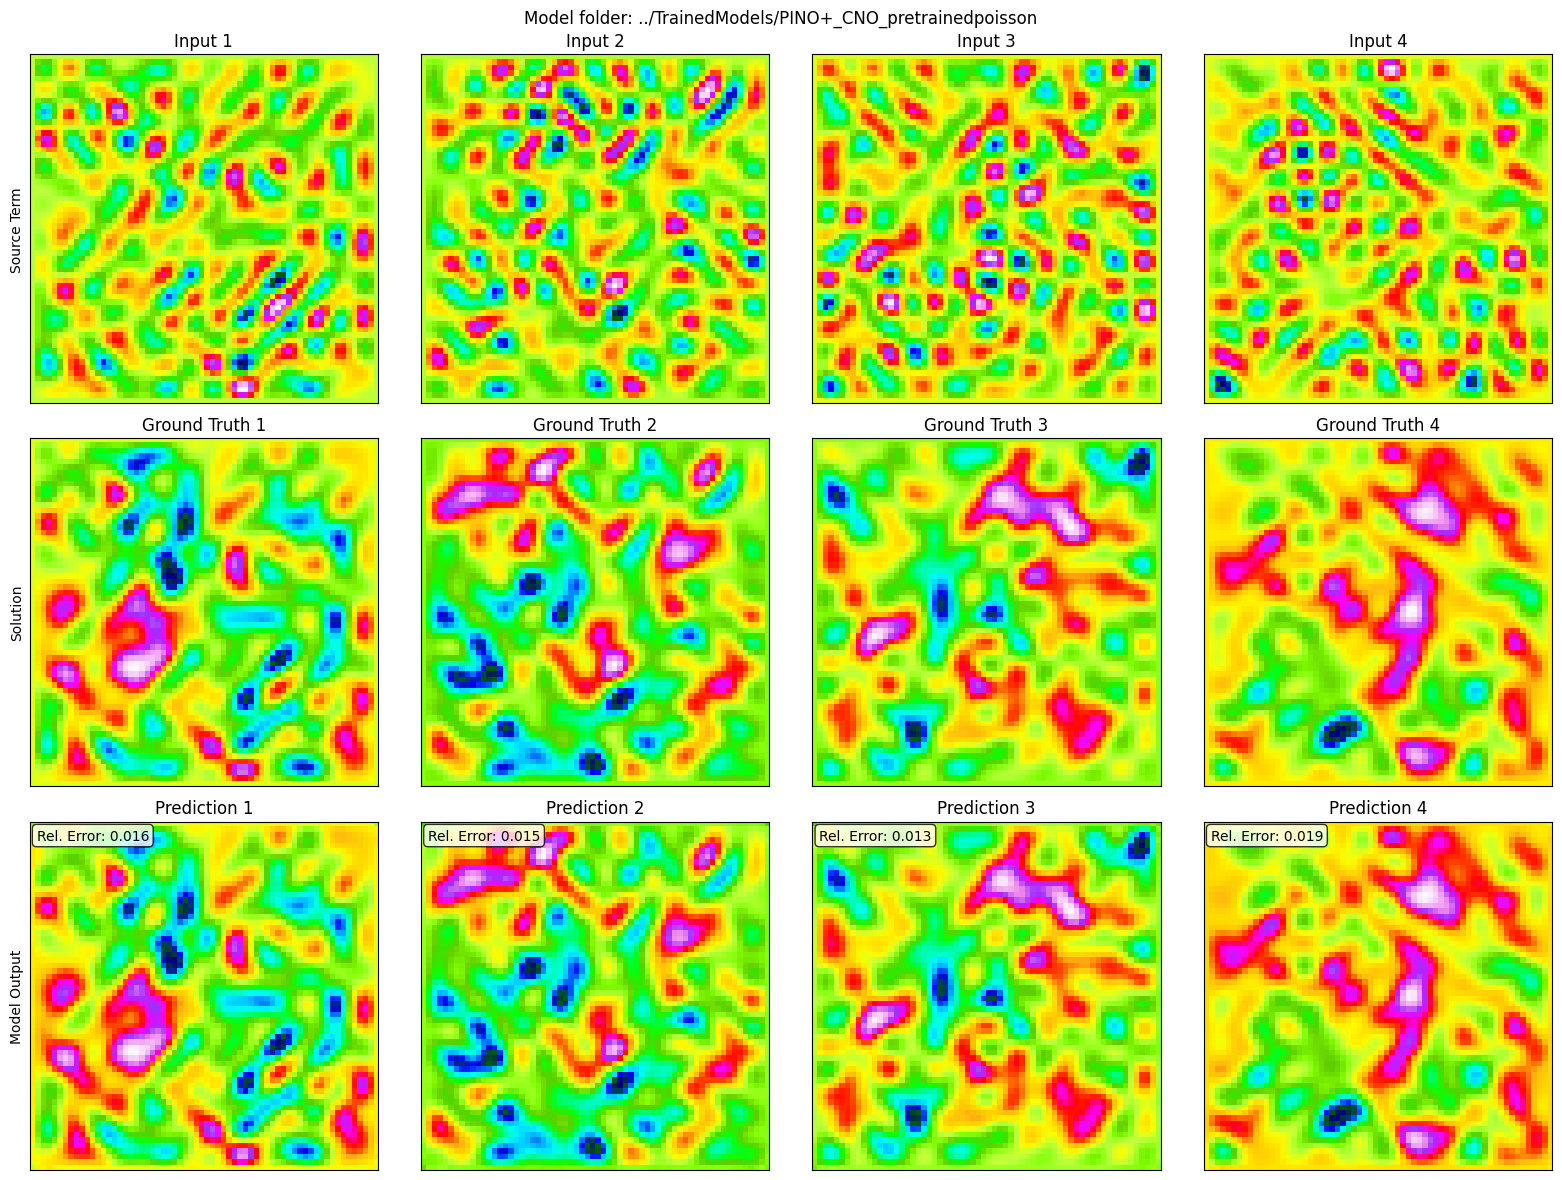

In [16]:
# Get multiple samples for visualization
num_samples = 4
test_iter = iter(poisson_data.test_loader)
input_batch, output_batch = next(test_iter)

# Take first few samples
input_batch = input_batch[:num_samples].to(device)
output_batch = output_batch[:num_samples].to(device)

# Get predictions
with torch.no_grad():
    prediction_batch = model(input_batch)

# Create visualization
fig, axes = plt.subplots(3, num_samples, figsize=(16, 12))

# add model_folder path as title
fig.suptitle(f"Model folder: {model_folder}")

for i in range(num_samples):
    # Convert to numpy
    input_sample = input_batch[i, 0].cpu().numpy()
    ground_truth = output_batch[i, 0].cpu().numpy()
    prediction = prediction_batch[i, 0].cpu().numpy()
    
    # Plot input
    im1 = axes[0, i].imshow(input_sample, cmap=cmap, origin='lower')
    axes[0, i].set_title(f'Input {i+1}')
    if i == 0:
        axes[0, i].set_ylabel('Source Term')
    
    # Plot ground truth
    im2 = axes[1, i].imshow(ground_truth, cmap=cmap, origin='lower')
    axes[1, i].set_title(f'Ground Truth {i+1}')
    if i == 0:
        axes[1, i].set_ylabel('Solution')
    
    # Plot prediction
    im3 = axes[2, i].imshow(prediction, cmap=cmap, origin='lower')
    axes[2, i].set_title(f'Prediction {i+1}')
    if i == 0:
        axes[2, i].set_ylabel('Model Output')
    
    # Calculate and display relative error
    rel_error = np.linalg.norm(ground_truth - prediction) / np.linalg.norm(ground_truth)
    axes[2, i].text(0.02, 0.98, f'Rel. Error: {rel_error:.3f}', 
                   transform=axes[2, i].transAxes, 
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                   verticalalignment='top')

# Remove axis ticks for cleaner look
for ax in axes.flat:
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()
